In [ ]:
#!pip install torchmetrics

In [ ]:
import torch
#import torch.nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn as nn
from torch import Tensor
#import torch.nn.functional as F
#from torch.utils.data import DataLoader
import math
from torchmetrics.regression import MeanAbsolutePercentageError

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

<ipython-input-28-90a04159f25e>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dpath = "/content/drive/MyDrive/FIND-A/data/"

In [ ]:
fit = pd.read_csv(dpath + 'fitted_values.csv')
sent = pd.read_csv(dpath + 'sentiment_res.csv', encoding='cp949')

### 데이터 전처리

In [ ]:
sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             50000 non-null  object 
 1   updown           50000 non-null  int64  
 2   filtered_nouns3  50000 non-null  object 
 3   sent_score       50000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [ ]:
fit.head()

,index,cpi,stock,housing_lease,housing_trading,coincident,ir,ex,land_price,gr
0,2020-02-01,100.129785,105.444674,86.067343,80.875038,100.563427,1.095067,1193.444382,0.292993,-1.531442
1,2020-03-01,100.162578,103.809292,86.161180,81.123099,100.302872,1.097569,1211.530343,0.278769,-1.343450
2,2020-04-01,99.902076,92.745528,86.191786,81.203381,99.693635,0.880210,1218.109117,0.262119,-1.223660
3,2020-05-01,99.356775,98.408421,86.179746,81.491508,98.757473,0.626974,1213.026559,0.265169,-1.862200
4,2020-06-01,99.358689,100.072573,86.196649,81.754894,98.163027,0.589962,1219.388960,0.276622,-1.405300


In [ ]:
# date 열을 문자열에서 날짜로 변환
sent['date'] = pd.to_datetime(sent['date'], format='%Y-%m-%d')

# 2020년 1월 데이터가 아닌 행 필터링
sent = sent[~((sent['date'].dt.year == 2020) & (sent['date'].dt.month == 1))]

In [ ]:
sent.head()

,date,updown,filtered_nouns3,sent_score
1042,2020-02-01,0,스포츠서울 김효원 경기도 시공사 인천 시공사 국토교통부 지자체 신도시 이름 공모전 ...,328.591639
1043,2020-02-01,0,아파트 입찰 실수 경매 계약 포기 경매 물건 가치 잘못 평가 거나 잔금 마련 자료 ...,-205.126534
1044,2020-02-01,0,국토 연구원 도시 정비 사업 관리 확대 방안 보고서 재건축 재개발 투명 위해 공공 ...,413.123887
1045,2020-02-01,0,청라 힐스 건설 제공 서울 국기 분양 시장 개막 초읽기 부동산 리서치 회사 닥터 아...,-4.864725
1046,2020-02-01,0,아시아 경제 문제 왕숙 늘빛 도시 신도시 대장 플로우 시티 국토교통부 한국 토지 주...,147.931636


In [ ]:
# 연도와 월에 대한 그룹화
sent['Year'] = sent['date'].dt.year
sent['Month'] = sent['date'].dt.month

<ipython-input-37-2f52e07fe6d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent['Year'] = sent['date'].dt.year
<ipython-input-37-2f52e07fe6d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent['Month'] = sent['date'].dt.month


In [ ]:
# Year와 Month를 합쳐서 date 열 생성
sent['date'] = sent.apply(lambda row: pd.to_datetime(f"{row['Year']}-{row['Month']}-01", format='%Y-%m-%d'), axis=1)

# 연도와 월에 대한 그룹화
sent_df = sent.groupby(['date']).agg({'updown': 'mean', 'sent_score': 'mean'}).reset_index()

In [ ]:
fit.head()

,index,cpi,stock,housing_lease,housing_trading,coincident,ir,ex,land_price,gr
0,2020-02-01,100.129785,105.444674,86.067343,80.875038,100.563427,1.095067,1193.444382,0.292993,-1.531442
1,2020-03-01,100.162578,103.809292,86.161180,81.123099,100.302872,1.097569,1211.530343,0.278769,-1.343450
2,2020-04-01,99.902076,92.745528,86.191786,81.203381,99.693635,0.880210,1218.109117,0.262119,-1.223660
3,2020-05-01,99.356775,98.408421,86.179746,81.491508,98.757473,0.626974,1213.026559,0.265169,-1.862200
4,2020-06-01,99.358689,100.072573,86.196649,81.754894,98.163027,0.589962,1219.388960,0.276622,-1.405300


In [ ]:
df = pd.concat([sent_df, fit], axis=1)

In [ ]:
df.set_index('date', inplace=True)

In [ ]:
df.drop('index', inplace=True, axis=1)

In [ ]:
df.head()

,updown,sent_score,cpi,stock,housing_lease,housing_trading,coincident,ir,ex,land_price,gr
date,,,,,,,,,,,
2020-02-01,0.00000,2.155920,100.129785,105.444674,86.067343,80.875038,100.563427,1.095067,1193.444382,0.292993,-1.531442
2020-03-01,0.00000,-12.703433,100.162578,103.809292,86.161180,81.123099,100.302872,1.097569,1211.530343,0.278769,-1.343450
2020-04-01,0.00000,-13.799276,99.902076,92.745528,86.191786,81.203381,99.693635,0.880210,1218.109117,0.262119,-1.223660
2020-05-01,0.00000,20.814559,99.356775,98.408421,86.179746,81.491508,98.757473,0.626974,1213.026559,0.265169,-1.862200
2020-06-01,0.50096,32.948290,99.358689,100.072573,86.196649,81.754894,98.163027,0.589962,1219.388960,0.276622,-1.405300


### 모델링

In [ ]:
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,
                         num_layers=num_layers,batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 =  Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
X = df.drop('housing_trading', axis=1) # X, y 분리
y = df[['housing_trading']]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler() # 0 ~ 1
ss = StandardScaler() # 평균 0, 분산 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:45, :]
X_test = X_ss[45:, :]

y_train = y_ms[:45, :]
y_test = y_ms[45:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (45, 10) (45, 1)
Testing Shape : (2, 10) (2, 1)


In [ ]:
# 데이터셋 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (45, 10) (45, 1)
Testing Shape : (2, 10) (2, 1)


In [ ]:
num_epochs = 100
learning_rate = 0.01

input_size=10
hidden_size=32
num_layers=1

num_classes=1
model=LSTM(num_classes,input_size,hidden_size,num_layers,X_train_tensors_f.shape[1])

criterion = MeanAbsolutePercentageError()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 1 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 336.13629
Epoch : 1, loss : 2660.38257
Epoch : 2, loss : 2312.60327
Epoch : 3, loss : 1141.75720
Epoch : 4, loss : 368.02435
Epoch : 5, loss : 636.44629
Epoch : 6, loss : 292.62436
Epoch : 7, loss : 318.88800
Epoch : 8, loss : 426.10919
Epoch : 9, loss : 236.82381
Epoch : 10, loss : 205.52359
Epoch : 11, loss : 277.41687
Epoch : 12, loss : 150.83246
Epoch : 13, loss : 156.19746
Epoch : 14, loss : 226.55663
Epoch : 15, loss : 106.94218
Epoch : 16, loss : 172.55647
Epoch : 17, loss : 246.08270
Epoch : 18, loss : 145.00026
Epoch : 19, loss : 101.91713
Epoch : 20, loss : 163.66464
Epoch : 21, loss : 69.30379
Epoch : 22, loss : 162.24672
Epoch : 23, loss : 220.87164
Epoch : 24, loss : 128.46576
Epoch : 25, loss : 93.66837
Epoch : 26, loss : 152.76099
Epoch : 27, loss : 71.06734
Epoch : 28, loss : 136.23734
Epoch : 29, loss : 187.07852
Epoch : 30, loss : 99.33073
Epoch : 31, loss : 108.62358
Epoch : 32, loss : 165.64650
Epoch : 33, loss : 91.20006
Epoch : 34, loss : 101.241

In [ ]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

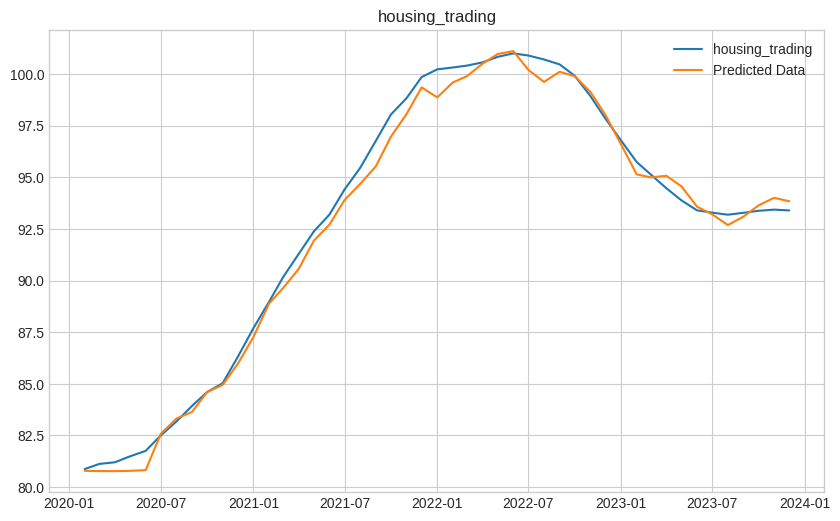

In [ ]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))

df['pred'] = predicted
plt.plot(df['housing_trading'], label='housing_trading')
plt.plot(df['pred'], label='Predicted Data')

plt.title('housing_trading')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(df['housing_trading'], predicted))
print("RMSE:", rmse)

RMSE: 0.5535142823728368
